In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from tensorflow.keras import Sequential
from keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, Activation, Dropout, Flatten, Input
import tensorflow as tf
from tensorflow.keras import backend as K
tf.random.set_seed(3)

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# import tensorflow.compat.v1.keras.backend as K 
# tf.compat.v1.disable_eager_execution()

In [2]:
def load_data(fileIn):
    
    allData = np.loadtxt(fileIn, skiprows=1)
    # all_df = pd.DataFrame(allData)
    # all_df.columns = allLabels
    
    cond = np.where(allData[:, -2] > 0)
    allData = allData[cond]
    # allData[:, -2] = np.log10(allData[:, -2])

    X = allData[:, :4]
    y = allData[:, 4:]
    return X, y

input_names = ['rx', 'ry', 'rz', 'dist']

In [3]:
num_epochs = 1000
batch_size = 4 #256
learning_rate = 1e-3 #1e-4
decay_rate = 0.01

# mode = 'train'
mode = 'test'

In [4]:


# load the dataset
fileIn = '../data/DOE1.out'
X, y = load_data(fileIn)

# encode strings to integer
#scaler = StandardScaler(with_mean=False)
# scaler = StandardScaler()
scaler = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
y = scaler.fit_transform(y)

# X_scaler = StandardScaler()
X_scaler = Pipeline([('stdscaler', StandardScaler()), ('minmax', MinMaxScaler(feature_range=(0, 1)))])
X = X_scaler.fit_transform(X)



# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# determine the number of input features
n_features = X_train.shape[1]
print(n_features)

(404, 4) (45, 4) (404, 2) (45, 2)
4


In [5]:
p_dropout = 0.001
# define model

model = Sequential()
model.add(Dense(16, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(p_dropout))
model.add(Dense(y.shape[1], activation='linear'))


# inputs = Input(((n_features)))
# x = Dense(16, activation="relu", kernel_initializer='he_normal')(inputs)
# x = Dense(32, activation="relu", kernel_initializer='he_normal')(x)
# x = Dense(128, activation="relu", kernel_initializer='he_normal')(x)
# x = Dropout(p_dropout)(x)
# predictions = Dense(y.shape[1], activation='linear')(x)
# model = Model(inputs=inputs, outputs=predictions)

In [6]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
K.set_value(model.optimizer.lr, learning_rate)
K.set_value(model.optimizer.decay, decay_rate)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,746
Trainable params: 1,746
Non-trainable params: 0
_________________________________________________________________


In [7]:

if mode == 'train': 
    # fit the model
    train_history = model.fit(X_train, y_train, epochs= num_epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    print('Test Accuracy: %.3f' % acc)
    # save the model
    tf.keras.models.save_model(model, '../model/mlp43', overwrite=True, include_optimizer=True, save_format=None, signatures=None, options=None)

    
if mode == 'train':
    plt.figure(2111)
    plt.plot(train_history.history['loss'], label = 'loss')
    # plt.plot(train_history.history['val_loss'], label = 'val loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [8]:
########################
########################
# load a trained model
model = tf.keras.models.load_model('../model/mlp43')

# make a prediction
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

########################


In [9]:
y_pred.shape, y_test.shape

((45, 2), (45, 2))

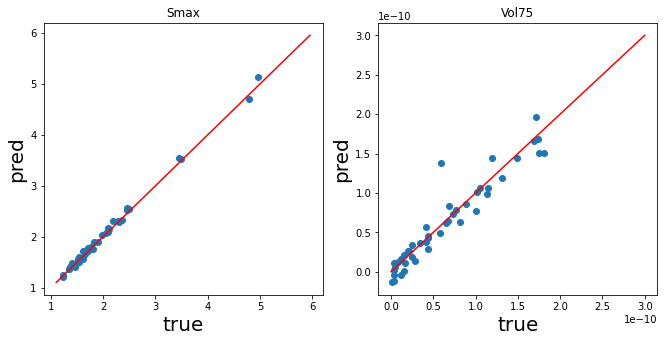

In [10]:
f, a = plt.subplots(1, 2, figsize=(11, 5))
allLabels = ['rx', 'ry', 'rz', 'dist', 'Smax', 'Vol75']

a[0].scatter(y_test[:, 0], y_pred[:, 0])
a[0].title.set_text(allLabels[4])
# a[0].set_xlim(0.2*np.min(y_test[:, 0]), 1.5*np.max(y_test[:, 0]))
# a[0].set_ylim(0.2*np.min(y_test[:, 0]), 1.5*np.max(y_pred[:, 0]))
a[0].set_xlabel('true', fontsize=20)
a[0].set_ylabel('pred', fontsize=20)
a[0].plot([0.9*np.min(y_test[:, 0]), 1.2*np.max(y_test[:, 0])], [0.9*np.min(y_test[:, 0]), 1.2*np.max(y_test[:, 0])], 'r')


a[1].scatter(y_test[:, 1], y_pred[:, 1])
a[1].title.set_text(allLabels[5])
# a[1].set_xlim(0.2*np.min(y_test[:, 1]), 1.5*np.max(y_test[:, 1]))
# a[1].set_ylim(0.2*np.min(y_test[:, 1]), 1.5*np.max(y_pred[:, 1]))
a[1].set_xlabel('true', fontsize=20)
a[1].set_ylabel('pred', fontsize=20)
a[1].plot([0,3e-10], [0,3e-10], 'r')

plt.savefig('../plots/mlp')
plt.show()

In [11]:
from tensorflow.python.keras.backend import eager_learning_phase_scope
from tensorflow.keras import backend as K

mc_samples = 100
f = K.function([model.layers[0].input], [model.output])
    
# Run the function for the number of mc_samples with learning_phase enabled
with eager_learning_phase_scope(value=1): # 0=test, 1=train
    Yt_hat = np.array([f((X_test))[0] for _ in range(mc_samples)])
    
y_mean = np.mean(Yt_hat, axis=0)
y_std = np.std(Yt_hat, axis=0)

y_mean = scaler.inverse_transform(y_mean)
y_std = scaler.inverse_transform(y_std)

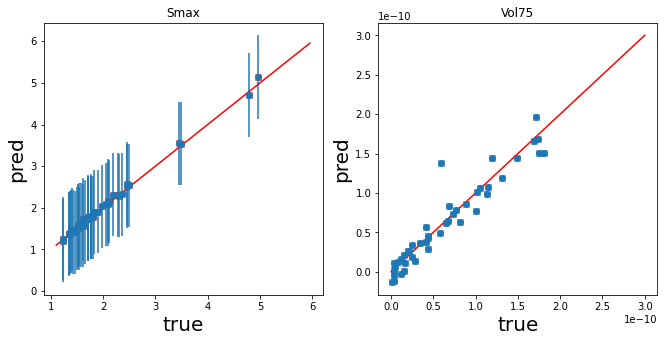

In [12]:
f, a = plt.subplots(1, 2, figsize=(11, 5))
allLabels = ['rx', 'ry', 'rz', 'dist', 'Smax', 'Vol75']

a[0].errorbar(y_test[:, 0], y_mean[:, 0], yerr = y_std[:, 0], fmt="o")
a[0].scatter(y_test[:, 0], y_pred[:, 0], marker='x', color='r')
a[0].title.set_text(allLabels[4])
# a[0].set_xlim(0.2*np.min(y_test[:, 0]), 1.5*np.max(y_test[:, 0]))
# a[0].set_ylim(0.2*np.min(y_test[:, 0]), 1.5*np.max(y_pred[:, 0]))
a[0].set_xlabel('true', fontsize=20)
a[0].set_ylabel('pred', fontsize=20)
a[0].plot([0.9*np.min(y_test[:, 0]), 1.2*np.max(y_test[:, 0])], [0.9*np.min(y_test[:, 0]), 1.2*np.max(y_test[:, 0])], 'r')


a[1].errorbar(y_test[:, 1], y_mean[:, 1], yerr = y_std[:, 1], fmt="o")
a[1].scatter(y_test[:, 1], y_pred[:, 1], marker='x')
a[1].title.set_text(allLabels[5])
# a[1].set_xlim(0.2*np.min(y_test[:, 1]), 1.5*np.max(y_test[:, 1]))
# a[1].set_ylim(0.2*np.min(y_test[:, 1]), 1.5*np.max(y_pred[:, 1]))
a[1].set_xlabel('true', fontsize=20)
a[1].set_ylabel('pred', fontsize=20)
a[1].plot([0,3e-10], [0,3e-10], 'r')

plt.savefig('../plots/mlp_drop')
plt.show()

In [13]:
# shap.__version__, tf.__version__

In [14]:
# import shap

In [15]:
# background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
# # shap.explainers.deep.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough

# explainer = shap.DeepExplainer( (model.layers[0].input, model.layers[-1].output), background )

# shap_values = explainer.shap_values(X_test[:3]) # <-- HERE !

# # print the JS visualization code to the notebook
# shap.initjs()
# # shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=X_train.columns)

In [16]:
# explainer = shap.DeepExplainer( model, background )
# shap_values = explainer.shap_values(X_test[:3])

In [17]:
# X_test.shape

In [18]:
# import shap

# # select a set of background examples to take an expectation over
# background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# # explain predictions of the model on three images
# # e = shap.DeepExplainer(model, background)
# e = shap.DeepExplainer( (model.layers[0].input, model.layers[-1].output), background)
# # ...or pass tensors directly
# # e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
# shap_values = e.shap_values(X_test[1:5])

In [19]:
from alibi.explainers import KernelShap
from alibi.explainers import IntegratedGradients
import shap

shap.initjs()


predictor = model.predict
# explainer = SomeExplainer(predictor), **kwargs)

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])
[0.03037703 0.03099696 0.         0.08812338] [ 0.          0.         -0.07629662  0.        ]


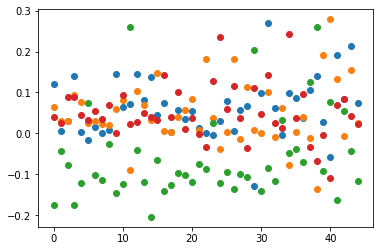

In [20]:
input_names = ['rx', 'ry', 'rz', 'dist']
target_names = ['Smax', 'Vol75']

# Initialize IntegratedGradients instance
n_steps = 50
method = "gausslegendre"
ig  = IntegratedGradients(model, n_steps=n_steps, method=method)

# Calculate attributions for the first 10 images in the test set
nb_samples = 100
X_test_sample = X_test[:nb_samples]
predictions = model(X_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(X_test_sample, baselines=None, target=predictions)

# Metadata from the explanation object
explanation.meta

# Data fields from the explanation object
print(explanation.data.keys())

# Get attributions values from the explanation object
attrs = explanation.attributions[0]
      
plt.plot(attrs, 'o')
      
      
image_id = 2
attr = attrs[image_id]
attr_pos = attr.clip(0, 1)
attr_neg = attr.clip(-1, 0)
      
      
print(attr_pos, attr_neg)

In [21]:
### X_train OR X_test???

ex = shap.KernelExplainer( predictor, X_train, features = input_names)
# ex = shap.KernelExplainer( predictor, X_test, features = input_names)

shap_values = ex.shap_values(X_test[0:nb_samples, :])
# shap.force_plot(ex.expected_value, shap_values[0], X_test[0:10,:])

Using 404 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/45 [00:00<?, ?it/s]

In [22]:
out_id = 0
target_id = 18
shap.force_plot(ex.expected_value[out_id], shap_values[out_id][4], feature_names = input_names, out_names = target_names[out_id])

In [23]:
out_id = 0
target_id = 18
shap.force_plot(ex.expected_value[out_id], shap_values[out_id][4], feature_names = input_names, out_names = target_names[out_id])

In [24]:
out_id = 1
target_id = 18
shap.force_plot(ex.expected_value[out_id], shap_values[out_id][4], feature_names = input_names, out_names = target_names[out_id])

In [25]:
out_id = 0
target_id = 35
shap.force_plot(ex.expected_value[out_id], shap_values[out_id][4], feature_names = input_names, out_names = target_names[out_id])

In [26]:
out_id = 1
target_id = 35
shap.force_plot(ex.expected_value[out_id], shap_values[out_id][4], feature_names = input_names, out_names = target_names[out_id])

In [27]:
out_id = 0
shap.force_plot(ex.expected_value[out_id], shap_values[out_id], feature_names = input_names, out_names = target_names[out_id])

In [28]:
out_id = 1
shap.force_plot(ex.expected_value[out_id], shap_values[out_id], feature_names = input_names, out_names = target_names[out_id])

In [29]:
# np.array(shap_values).shape

In [30]:
# shap.force_plot(ex.expected_value[1], shap_values[1][44], feature_names = input_names)

In [31]:
shap_values[0].shape, X_test.shape, ex.expected_value.shape, np.array(shap_values).shape

((45, 4), (45, 4), (2,), (2, 45, 4))

In [32]:
explainer = shap.KernelExplainer(predictor, X_train, features = input_names, out_names = target_names)
shap_valuesKE = explainer.shap_values(X_test)

Using 404 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/45 [00:00<?, ?it/s]

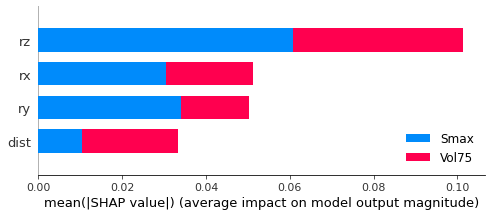

In [33]:
shap.summary_plot(shap_valuesKE, X_test, feature_names = input_names, class_names=target_names)

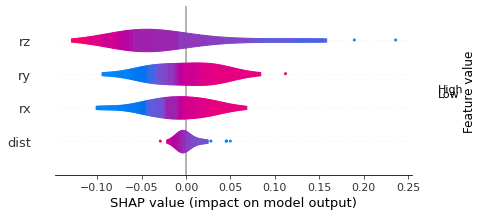

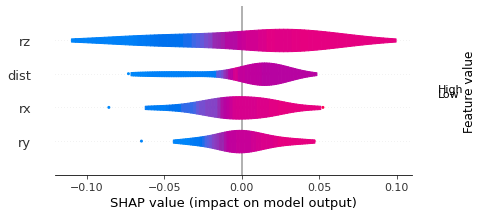

In [34]:
shap.summary_plot(shap_valuesKE[0], X_test, feature_names = input_names, plot_type='violin')
shap.summary_plot(shap_valuesKE[1], X_test, feature_names = input_names, plot_type='violin')

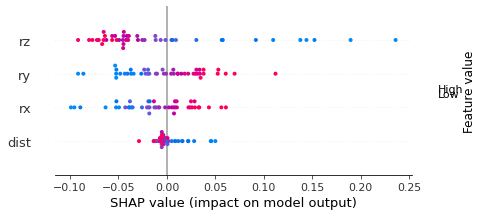

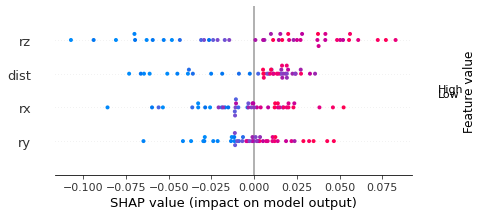

In [35]:
shap.summary_plot(shap_valuesKE[0], X_test, feature_names = input_names, plot_type='dot')
shap.summary_plot(shap_valuesKE[1], X_test, feature_names = input_names, plot_type='dot')

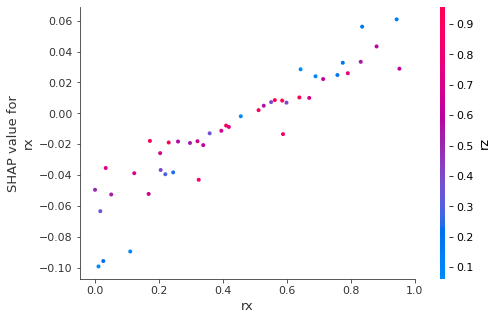

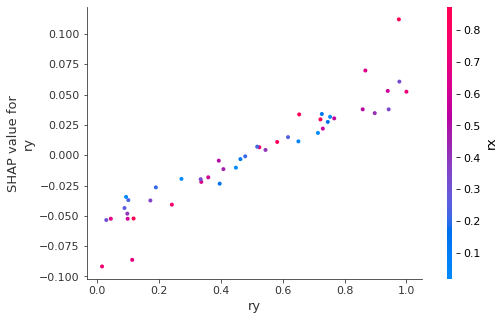

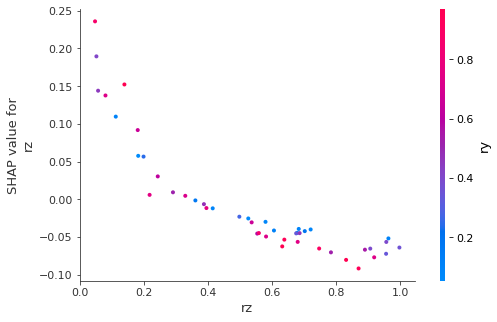

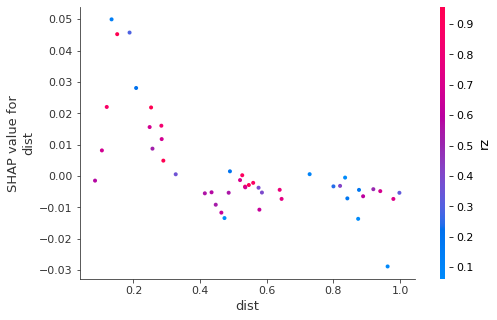

In [36]:
shap.dependence_plot(0, shap_valuesKE[0], X_test, feature_names = input_names)
shap.dependence_plot(1, shap_valuesKE[0], X_test, feature_names = input_names)
shap.dependence_plot(2, shap_valuesKE[0], X_test, feature_names = input_names)
shap.dependence_plot(3, shap_valuesKE[0], X_test, feature_names = input_names)

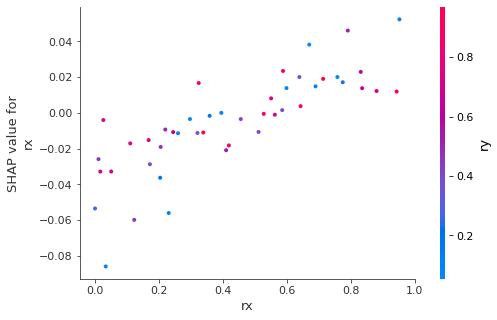

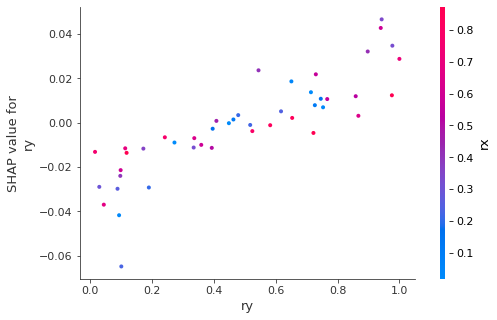

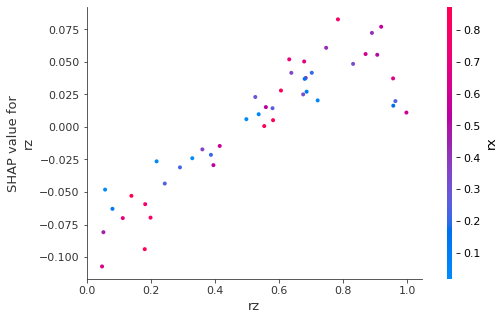

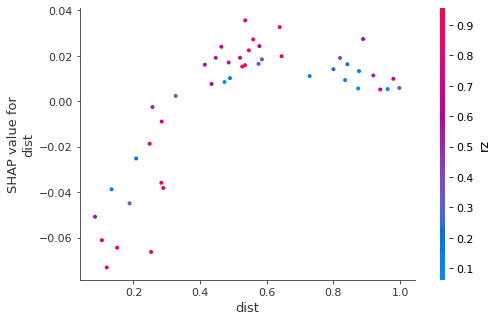

In [37]:
shap.dependence_plot(0, shap_valuesKE[1], X_test, feature_names = input_names)
shap.dependence_plot(1, shap_valuesKE[1], X_test, feature_names = input_names)
shap.dependence_plot(2, shap_valuesKE[1], X_test, feature_names = input_names)
shap.dependence_plot(3, shap_valuesKE[1], X_test, feature_names = input_names)

In [38]:
# shap.plots.heatmap(shap_values)

In [39]:
# shap.force_plot(ex.expected_value[1], shap_values[0], feature_names = input_names)

In [40]:
# shap.force_plot(ex.expected_value[1], shap_values[1], feature_names = input_names)

In [41]:
# shap.force_plot(ex.expected_value[1], shap_values[1][32], feature_names = input_names)

In [42]:
# shap_values = explainer(X_test)
# shap.partial_dependence_plot(3, shap_values[1], X_test, feature_names = input_names)
# # shap.plots.waterfall(shap_values[sample_ind], max_display=14)

In [43]:
input_names

['rx', 'ry', 'rz', 'dist']

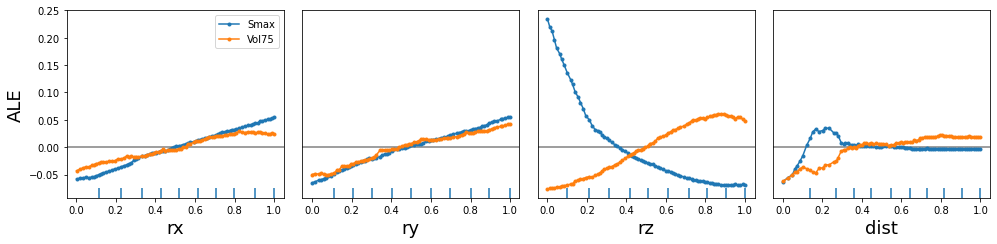

In [44]:
# Global vs local explain
# https://docs.seldon.io/projects/alibi/en/latest/overview/high_level.html#global-feature-attribution
# https://docs.seldon.io/projects/alibi/en/latest/methods/ale_figures.html?highlight=plot_ale#ALE-Figures


from alibi.explainers import ALE
from alibi.explainers import plot_ale

input_names = ['rx', 'ry', 'rz', 'dist']
target_names = ['Smax', 'Vol75']

ale = ALE(predictor, feature_names=input_names, target_names= target_names)
exp = ale.explain(X_train)
# plot_ale(exp, features=['rx'], line_kw={'label': 'Probability of "good" class'})
# plot_ale(exp, features=['ry'], line_kw={'label': 'Probability of "good" class'})
# plot_ale(exp, features=['rz'], line_kw={'label': 'Probability of "good" class'})
# plot_ale(exp, features=['dist'], line_kw={'label': 'Probability of "good" class'})

fig, ax = plt.subplots(1, 4, figsize=(14, 3.5), sharey=True)
ax[0].set_xlabel(input_names[0], fontsize=18)
ax[1].set_xlabel(input_names[1], fontsize=18)
ax[2].set_xlabel(input_names[2], fontsize=18)
ax[3].set_xlabel(input_names[3], fontsize=18)
ax[0].set_ylabel(ALE, fontsize=18)

plot_ale(exp, features=input_names, ax = ax, sharey=True, constant=False)

ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

# ax[0].legend(fontsize=18)

In [45]:
np.array(exp.data['ale_values']).shape, X_train.shape

((4, 81, 2), (404, 4))

In [46]:
input_names

[0, 1, 2, 3]

In [47]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# plot_ale(exp, features=[0], ax=ax[0]);
# plot_ale(exp, features=[1], ax=ax[1]);

In [48]:
# # compute the SHAP values for the linear model
# explainer = shap.Explainer(predictor, X_train)
# shap_values = explainer(X)

# # make a standard partial dependence plot
# sample_ind = 18
# shap.partial_dependence_plot(
#     "dist", predictor, X_train, model_expected_value=True,
#     feature_expected_value=True, ice=False,
#     shap_values=shap_values[sample_ind:sample_ind+1,:]
# )

In [49]:
# shap.plots.scatter(shap_values[:,"dist"])


In [50]:
# # the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
# shap.plots.waterfall(shap_values[sample_ind], max_display=14)